In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

In [2]:
df = pd.read_excel('/Users/hiraokatatsuru/Library/CloudStorage/OneDrive-個人用/ドキュメント/物数データ.xlsx')
df.set_index('date', inplace=True)

In [3]:
df

,通常物数
date,
2021-10-01,63000
2021-10-02,0
2021-10-03,0
2021-10-04,102000
2021-10-05,45000
...,...
2025-05-27,29000
2025-05-28,32000
2025-05-29,36000


In [6]:
def assign_season(date):
    if date.month in [3, 4, 5]:
        return 1  # 春
    elif date.month in [6, 7, 8]:
        return 2  # 夏
    elif date.month in [9, 10, 11]:
        return 3  # 秋
    else:
        return 4  # 冬


In [4]:
def generate_features(df, dates, feature_columns):
    idx    = df.index.union(dates)
    df_ext = df.reindex(idx)

    # 曜日系
    df_ext['dow']     = df_ext.index.dayofweek
    df_ext['dow_sin'] = np.sin(2*np.pi*df_ext['dow']/7)
    df_ext['dow_cos'] = np.cos(2*np.pi*df_ext['dow']/7)

    # 祝日系
    df_ext['is_holiday']             = df_ext.index.to_series().apply(jpholiday.is_holiday).astype(int)
    df_ext['is_after_holiday']       = df_ext['is_holiday'].shift(1).fillna(0).astype(int)
    df_ext['is_after_after_holiday'] = df_ext['is_holiday'].shift(2).fillna(0).astype(int)

    # 月・年末年始・お盆
    df_ext['month']       = df_ext.index.month
    df_ext['season'] = df_ext.index.map(assign_season)
    df_ext['is_new_year'] = ((df_ext.index.month == 1) & (df_ext.index.day <= 3)).astype(int)
    df_ext['is_obon']     = (
        (df_ext.index.month == 8) &
        (df_ext.index.day   >= 13) &
        (df_ext.index.day   <= 16)
    ).astype(int)

    # ラグ・移動平均
    df_ext['lag_1']          = df_ext['通常物数'].shift(1)
    df_ext['lag_7']          = df_ext['通常物数'].shift(7)
    df_ext['rolling_mean_7'] = df_ext['通常物数'].shift(1).rolling(7).mean()

    # 価格増加フラグ
    df_ext['price_increase_flag'] = 0
    df_ext.loc[df_ext.index >= pd.Timestamp('2024-10-01'), 'price_increase_flag'] = 1

    # 最終的に欲しい行・列を抽出
    return df_ext.loc[dates, feature_columns]


Fold 1: MAE = 5174.45, RMSE = 9225.12
Fold 2: MAE = 5230.42, RMSE = 9605.34
Fold 3: MAE = 4560.24, RMSE = 9595.03
Fold 4: MAE = 4478.44, RMSE = 8595.56
Fold 5: MAE = 5533.39, RMSE = 9992.13

===== Cross-Validation Result (TimeSeriesSplit) =====
Average MAE : 4995.39
Average RMSE: 9402.64


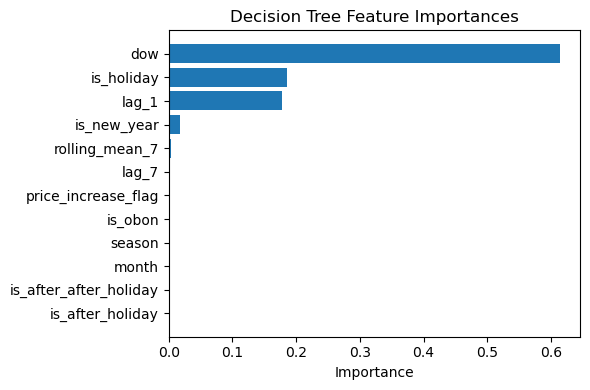

In [7]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# 1. 特徴量と目的変数の準備
# ------------------------------------------------------------------------------
# 1. 学習時に使う特徴量リストを定義
feature_columns = [#'dow_sin','dow_cos',
    'dow',
    'is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7','is_new_year','is_obon','price_increase_flag'
]

X = generate_features(df, df.index, feature_columns)

# 3. 目的変数を揃える
y = df['通常物数'].loc[X.index]

# 4. 欠損行（ラグ計算で NaN が出る最初の数行）を削除
mask   = X.isnull().any(axis=1)
X  = X.loc[~mask]
y  = y.loc[~mask]

# ------------------------------------------------------------------------------
# 2. 時系列分割の設定
# ------------------------------------------------------------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# ------------------------------------------------------------------------------
# 3. 各 Fold で学習・検証
# ------------------------------------------------------------------------------
model_dt = DecisionTreeRegressor(
    max_depth=5,
    random_state=42
)

mae_list = []
rmse_list = []

for fold_index, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 学習
    model_dt.fit(X_train, y_train)
    
    # 検証データで予測
    y_pred = model_dt.predict(X_val)
    
    # 評価指標を計算
    mae  = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_list.append(mae)
    rmse_list.append(rmse)
    
    print(f"Fold {fold_index}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

# ------------------------------------------------------------------------------
# 4. Cross-Validation 結果の平均を出力
# ------------------------------------------------------------------------------
print("\n===== Cross-Validation Result (TimeSeriesSplit) =====")
print(f"Average MAE : {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")

# ------------------------------------------------------------------------------
# 4. 特徴量重要度の可視化
# ------------------------------------------------------------------------------
importances = model_dt.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [1, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20],
}
# TimeSeriesSplit を CV に使う
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)
grid.fit(X, y)
print("Best params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)


Best params: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best RMSE: 8798.386921782409


Training   MAE: 5829.77, RMSE: 10497.62


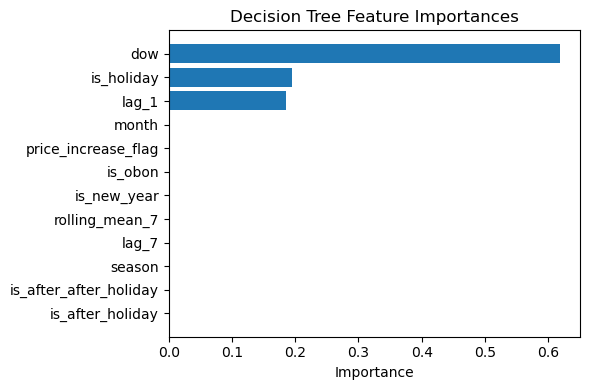

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------------------------
# 前提：df, feature_columns, y は先ほどと同様に準備済み
# ------------------------------------------------------------------------------
feature_columns = [#'dow_sin','dow_cos',
    'dow',
    'is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7','is_new_year','is_obon','price_increase_flag'
]

X = generate_features(df, df.index, feature_columns)

# 3. 目的変数を揃える
y = df['通常物数'].loc[X.index]

# 4. 欠損行（ラグ計算で NaN が出る最初の数行）を削除
mask   = X.isnull().any(axis=1)
X  = X.loc[~mask]
y  = y.loc[~mask]

# ------------------------------------------------------------------------------
# 1. 全データで再学習
# ------------------------------------------------------------------------------
best_params = {
    'max_depth': 3,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'random_state': 42
}
model_final = DecisionTreeRegressor(**best_params)
model_final.fit(X, y)

# ------------------------------------------------------------------------------
# 2. モデルの自己評価（全データ学習後の誤差を確認）
# ------------------------------------------------------------------------------
y_pred_full = model_final.predict(X)
mae_full  = mean_absolute_error(y, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))
print(f"Training   MAE: {mae_full:.2f}, RMSE: {rmse_full:.2f}")

# ------------------------------------------------------------------------------
# 4. 特徴量重要度の可視化
# ------------------------------------------------------------------------------
importances = model_final.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh([feature_columns[i] for i in idx], importances[idx])
plt.xlabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:

# 予測対象の期間を設定
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=365)

# 予測のためのデータフレームを準備
future_df = pd.DataFrame(index=future_dates)
future_df['dow'] = future_df.index.dayofweek  # 曜日（0: 月, ..., 6: 日）
future_df['is_holiday'] = future_df.index.map(jpholiday.is_holiday)  # 祝日フラグ（祝日データ要追加）
#future_df['season'] = future_df.index.month % 12 // 3 + 1  # 季節（例: 1: 春, 2: 夏, ...）
#future_df['is_weekend_or_holiday'] = ((future_df['weekday'] >= 5) | (future_df['is_holiday'] == 1)).astype(int)
future_df['is_obon'] = (
    (future_df.index.month == 8) & 
    (future_df.index.day >= 10) & 
    (future_df.index.day <= 20)).astype(int)

future_df['month'] = future_df.index.month
# 年末年始フラグ（12月29〜1月5日、土日祝を除く）
future_df['is_new_year'] = (
    (((future_df.index.month == 12) & (future_df.index.day >= 26)) | 
     ((future_df.index.month == 1) & (future_df.index.day <= 10)))).astype(int)
future_df['is_after_holiday'] = (
        (future_df['is_holiday'].shift(1) == 1) & 
        (future_df['is_holiday'] == 0)
    ).astype(int)
    
# 前日が "祝日明け" フラグ == 1 かつ 当日は祝日ではない → "祝日明けの翌日"
future_df['is_after_after_holiday'] = (
    (future_df['is_after_holiday'].shift(1) == 1) &
    (future_df['is_holiday'] == 0)
).astype(int)
future_df['is_weekend_or_holiday'] = ((future_df['dow'] >= 5) | (future_df['is_holiday'] == 1)).astype(int)
future_df = df.loc['2023-01-01':].copy()

# フラグ追加
future_df['price_increase_flag'] = (df_2023.index >= pd.Timestamp('2024-10-01')).astype(int)
future_df['dow_sin'] = np.sin(2 * np.pi * future_df['dow'] / 7)
future_df['dow_cos'] = np.cos(2 * np.pi * future_df['dow'] / 7)


# 予測をループで行う
predictions = []

# 最初の状態をセット（最後のデータから履歴を取得）
lag_1 = df['通常物数'].iloc[-1]
lag_7 = df['通常物数'].iloc[-7:].mean()
rolling_mean_7 = df['通常物数'].iloc[-7:].mean()

for date in future_dates:
    # 特徴量を準備
    features = {
        'is_after_holiday': future_df.loc[date, 'is_after_holiday'],
        'is_after_after_holiday': future_df.loc[date, 'is_after_after_holiday'],
        'month': future_df.loc[date, 'month'],
        'lag_1': lag_1,
        'lag_7': lag_7,
        'rolling_mean_7': rolling_mean_7,
        'is_new_year': future_df.loc[date, 'is_new_year'],
        'is_obon': future_df.loc[date, 'is_obon'],
        'is_holiday': future_df.loc[date, 'is_holiday'],
        #'season': future_df.loc[date, 'season'],
        'dow': future_df.loc[date, 'dow'],
        'is_weekend_or_holiday': future_df.loc[date, 'is_weekend_or_holiday'],
        'price_increase_flag': future_df.loc[date, 'price_increase_flag'],
        'dow_sin': future_df.loc[date, 'dow_sin'],
        'dow_cos': future_df.loc[date, 'dow_cos']
    }
    # 特徴量をデータフレーム形式に変換
    X_future = pd.DataFrame([features])
    
    # 予測値を取得
    pred = model_dt.predict(X_future)[0]
    predictions.append(pred)
    
    # 履歴を更新
    lag_1 = pred
    lag_7 = (lag_7 * 6 + pred) / 7  # 過去7日の移動平均を更新
    rolling_mean_7 = lag_7  # 同じ計算なので更新

# 予測結果を格納
future_df['通常物数'] = predictions

# 四捨五入して千通単位で表示
future_df['通常物数'] = future_df['通常物数'].round(-3).astype(int)

future_df_adjusted = carry_over_weekend_holiday(
    df=future_df,
    target_col='通常物数',  # 決定木の予測値を繰り越す場合
    is_weekend_or_holiday_col='is_weekend_or_holiday'
)

# 結果を表示
for date, row in future_df.iterrows():
    weekday_char = ['月', '火', '水', '木', '金', '土', '日'][row['dow']]
    holiday_flag = "祝" if row['is_holiday'] else ""
    print(f"{date.strftime('%Y-%m-%d')} ({weekday_char}{holiday_flag}): {row['通常物数']} 通")


NameError: name 'df_2023' is not defined

In [26]:
# 土日祝日の予測を繰り越す関数
def carry_over_weekend_holiday(df, target_col, is_weekend_or_holiday_col):
    # データフレームをコピー
    df = df.copy()

    # 日付リストを取得
    dates = df.index

    # 土日祝日の繰り越し
    for i, date in enumerate(dates):
        if df.loc[date, is_weekend_or_holiday_col] == 1:  # 土日祝日
            # 予測値
            carry_value = df.loc[date, target_col]

            # 次の平日を探す
            next_date = None
            for next_idx in range(i + 1, len(dates)):
                if df.loc[dates[next_idx], is_weekend_or_holiday_col] == 0:  # 平日
                    next_date = dates[next_idx]
                    break

            # 次の平日に加算
            if next_date:
                df.loc[next_date, target_col] += carry_value

            # 土日祝日の予測値を0にする
            df.loc[date, target_col] = 0

    return df

In [10]:
# ── 1. 未来インデックスと特徴量リスト ──
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1),
                             periods=365, freq='D')
feature_columns = [#'dow_sin','dow_cos',
    'dow',
    'is_holiday','is_after_holiday','is_after_after_holiday',
    'month','season','lag_1','lag_7','rolling_mean_7','is_new_year','is_obon','price_increase_flag'
]

# ── 2. 未来特徴量を一括生成 ──
X_future = generate_features(df, future_dates, feature_columns)

# ── 3. 予測ループ ──
history = df['通常物数'].copy()
carry   = 0.0
preds   = pd.Series(index=future_dates, dtype=float)

for dt in future_dates:
    raw = model_final.predict(X_future.loc[[dt]])[0]
    is_wh = jpholiday.is_holiday(dt) or dt.weekday() >= 5
    if is_wh:
        carry += raw
        pred = 0.0
    else:
        pred = raw + carry
        carry = 0.0
    preds[dt]    = pred
    history[dt]  = pred        # lag/rolling 用に履歴を更新

# ── 4. DataFrame にまとめ ──
future_df = preds.to_frame(name='通常物数')

# ── 5. 曜日・祝日列を追加（表示に使うだけ）──
future_df['weekday']    = future_df.index.dayofweek
future_df['is_holiday'] = future_df.index.to_series().apply(jpholiday.is_holiday).astype(int)

# ── 6. 千通単位で四捨五入 ──
future_df['通常物数'] = future_df['通常物数'].round(-3).astype(int)

# ── 7. 行ごとに成型して出力 ──
weekday_map = ['月','火','水','木','金','土','日']
for date, row in future_df.iterrows():
    wd = weekday_map[row['weekday']]
    hk = '祝' if row['is_holiday'] else ''
    print(f"{date.strftime('%Y-%m-%d')} ({wd}{hk}): {row['通常物数']} 通")

# ── 8. 必要なら future_df を返す / 保存する ──


2025-06-01 (日): 0 通
2025-06-02 (月): 45000 通
2025-06-03 (火): 45000 通
2025-06-04 (水): 45000 通
2025-06-05 (木): 45000 通
2025-06-06 (金): 45000 通
2025-06-07 (土): 0 通
2025-06-08 (日): 0 通
2025-06-09 (月): 45000 通
2025-06-10 (火): 45000 通
2025-06-11 (水): 45000 通
2025-06-12 (木): 45000 通
2025-06-13 (金): 45000 通
2025-06-14 (土): 0 通
2025-06-15 (日): 0 通
2025-06-16 (月): 45000 通
2025-06-17 (火): 45000 通
2025-06-18 (水): 45000 通
2025-06-19 (木): 45000 通
2025-06-20 (金): 45000 通
2025-06-21 (土): 0 通
2025-06-22 (日): 0 通
2025-06-23 (月): 45000 通
2025-06-24 (火): 45000 通
2025-06-25 (水): 45000 通
2025-06-26 (木): 45000 通
2025-06-27 (金): 45000 通
2025-06-28 (土): 0 通
2025-06-29 (日): 0 通
2025-06-30 (月): 45000 通
2025-07-01 (火): 45000 通
2025-07-02 (水): 45000 通
2025-07-03 (木): 45000 通
2025-07-04 (金): 45000 通
2025-07-05 (土): 0 通
2025-07-06 (日): 0 通
2025-07-07 (月): 45000 通
2025-07-08 (火): 45000 通
2025-07-09 (水): 45000 通
2025-07-10 (木): 45000 通
2025-07-11 (金): 45000 通
2025-07-12 (土): 0 通
2025-07-13 (日): 0 通
2025-07-14 (月): 4500